## Using pixel intensity thresholding to segment the entire mosquito antennal lobe

This notebook is kept tidy by modularizing the data and code into separate python files that are imported here.

In [80]:
# import packages
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
import glob
import pandas as pd
from collections import defaultdict
import caiman as cm
import skimage as ski


See `experiment_info.py` to specify important details related to the experiment. If you have different experiments, simply store the info in a separate python file and change the name `experiment_info` in the cell below.

**NOTE**: There should be as many .tif videos as there are odors, and it is assumed that these videos are alphanumerically labeled in the same order as they appear in `odor_string`. I.e., if I sort the names of the videos, the first one should correspond to the first odor in `odor_string`.

If you see `AssertionError`, see the comment after the error message!

In [37]:
# import important experimental variables
from experiment_info import samples, data_dir
from experiment_info import odor_encodings, odor_string
from experiment_info import x_dim, y_dim, z_dim, n_frames_to_analyze

print(f'data directory: {data_dir}')
print(f'Number of samples: {len(samples)}')
odor_list = odor_string.split('_')
print(f'Number of odors: {len(odor_list)}')
print(f'x,y,z dimensions: {x_dim}, {y_dim}, {z_dim}')
print(f'Number of frames to analyze: {n_frames_to_analyze}')

# sanity checks
assert os.path.isdir(data_dir), f'Data directory does not exist: {data_dir}'
for samp in samples:
    assert os.path.isdir(f"{data_dir}/{samp}"), f"directory {data_dir}/{samp} containing tif files does not exist! Is there one approppriately-named subdirectory per sample?"
for odor in odor_list:
    assert odor in odor_encodings, f"Odor {odor} not found in odor_encodings dictionary. Please add it to experiment_info.py"

data directory: /jukebox/mcbride/bjarnold/new_analysis/data/Mar_22_2024/1_RegisteredBrains
Number of samples: 15
Number of odors: 72
x,y,z dimensions: 128, 128, 24
Number of frames to analyze: 112


### Get full file paths for all videos, per sample.
Note that this finds **all** videos per sample. We potentially select a subset of these later on.

In [33]:
videos = {}
for samp in samples:
    v = glob.glob(f"{data_dir}/{samp}/*.tif")
    v = sorted(v)
    num_vids = len(v)
    assert num_vids == num_odors, f"I found {num_vids} videos for sample {samp}, but there are {num_odors} odors. The number of videos and odors should be equivalent."
    videos[samp] = v

### If you are intererested in a subset of odors/videos, specify them in the `odors_of_interest` list. 
### Otherwise leave it empty by removing everything b/t square brackets `[]`.

In [48]:
odors_of_interest = ['octanal4.58', 
                    'decanal4.53']

# for the specified odors of interest, get the indices of these odors in the odor_list
odor_of_interest_indices = []
if odors_of_interest:
    for i,odor in enumerate(odor_list):
        if odor_encodings[odor] in odors_of_interest:
            # print(i, odor, odor_encodings[odor])
            odor_of_interest_indices.append(i)
else:
    odor_of_interest_indices = range(len(odor_list))

print(f"According to your odors of interest, I was able to find this many in the odor_list: {len(odor_of_interest_indices)}") 
# print("for first sample in list, get the name of files with this odor:")
# tmp = [videos[samples[0]][i].split('/')[-1] for i in odor_of_interest_indices]
# for i in tmp:
#     print(i)

According to your odors of interest, I was able to find this many in the odor_list: 4


In [49]:
def reshape(Y, x_dim, y_dim, z_dim):
    # 1st dimension of Y is time X z_stacks, so reshape according to specified z_stacks
    try:
        Y_reshaped = np.reshape(Y, (int(Y.shape[0]/z_dim), z_dim, x_dim, y_dim))
    except ValueError:
        print(f"Y.shape: {Y.shape}, x_dim: {x_dim}, y_dim: {y_dim}, z_dim: {z_dim}")
        raise ValueError("The dimensions of the video are not compatible with the specified x,y,z dimensions. Please check the dimensions of the video and the x,y,z dimensions specified in experiment_info.py")
    # transpose to (n_frames, x, y, z)
    Y_reshaped2 = np.transpose(Y_reshaped, (0, 2, 3, 1))
    return Y_reshaped2

def background_normalize(Y, offset=1000):
    # Y has shape (frames, x,y,z), first 20 frames are background
    Y = Y + offset
    background = np.mean(Y[0:20,:,:,:], axis=0) # get mean of each pixel for 1st 20 frames
    Y_normalized = (Y - background)/(background+0.0000000000000000000001) # subtract and divide by background
    return Y_normalized

def load_videos_into_list(videos, odor_of_interest_indices, n_frames, normalize=False):
    Y_list = []
    for i in odor_of_interest_indices:
        Y = cm.load(videos[i])
        Y = reshape(Y, x_dim, y_dim, z_dim)
        assert Y.shape[0] >= n_frames, f"Number of frames in video is less than n_frames_to_analyze. Please specify a smaller number of frames to analyze."
        Y = Y[:n_frames] # only analyze first n_frames
        if normalize:
            Y = background_normalize(Y)
        Y_list.append(Y)
    return Y_list

def find_binary_mask(Y):
    # temporal smoothing
    Y_smoothed = np.mean(Y, axis=0)
    # spatial smoothing, median filter across pixels
    Y_smoothed = ski.filters.median(Y_smoothed, behavior='ndimage')
    # thresholding
    thresh = ski.filters.threshold_otsu(Y_smoothed)
    binary_mask = Y_smoothed > thresh 
    return binary_mask

### For each sample, concatenate all videos and threshold to segment AL.
For thresholding, we are currently using `ski.filters.threshold_otsu`

In [53]:
# data reloaded to ensure cell runs independently
binary_masks = {}
for samp in videos:
    Y_list = load_videos_into_list(videos[samp], odor_of_interest_indices, n_frames_to_analyze, normalize=False)
    Y = cm.concatenate(Y_list)

    binary_mask = find_binary_mask(Y)
    print(f"fraction of volume containing AL segment for sample {samp}: ", np.sum(binary_mask)/(x_dim*y_dim*z_dim))
    binary_masks[samp] = binary_mask


fraction of volume containing AL segment for sample 230913_ORL_GCaMP6f_F1:  0.09921518961588542
fraction of volume containing AL segment for sample 230913_ORL_GCaMP6f_F2:  0.11529795328776042
fraction of volume containing AL segment for sample 230914_ORL_GCaMP6f_F1:  0.11047617594401042
fraction of volume containing AL segment for sample 230914_ORL_GCaMP6f_F2:  0.09208933512369792
fraction of volume containing AL segment for sample 230915_ORL_GCaMP6f_F1:  0.10238393147786458
fraction of volume containing AL segment for sample 230913_U52_GCaMP6f_F2:  0.11143747965494792
fraction of volume containing AL segment for sample 230913_U52_GCaMP6f_F3:  0.11980438232421875
fraction of volume containing AL segment for sample 230914_U52_GCaMP6f_F1:  0.10930379231770833
fraction of volume containing AL segment for sample 230914_U52_GCaMP6f_F2:  0.08961741129557292
fraction of volume containing AL segment for sample 230915_U52_GCaMP6f_F2:  0.07548777262369792
fraction of volume containing AL segment

## Look at 2D projections of 3D binary masks
Change the index of samples to look at different samples

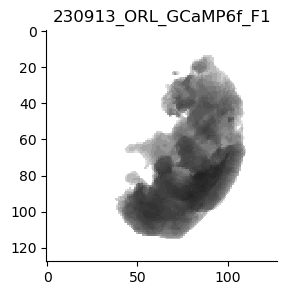

In [96]:
# change sample index
samp = samples[0]

colors = [(0, 0, 0, 0), (0, 0, 0, 0.1)]  # RGBA tuples, the 1st color's alpha set to 0 to make transparent so white values are ignores, black values are partially transparent; 0's mapped to 1st color, 1's mapped to 2nd color
cmap = ListedColormap(colors)
fig, ax = plt.subplots(1,1, figsize=(3,3))
for i in range(0,24):
    plt.imshow(binary_masks[samp][:,:,i], cmap=cmap)
plt.title(samples[0])
sns.despine()

### Within each AL segment, compute mean activity over time

In [57]:
# reload data, normalizing videos
def extract_mean_activity_within_binary_mask(Y, binary_mask, x_dim, y_dim, z_dim):
    # vectorize both the binary mask and the video
    binary_volume_R = np.reshape(binary_mask, (x_dim*y_dim*z_dim))
    Y_R = np.reshape(Y, (Y.shape[0], -1))
    Y_R = np.array(Y_R)
    print(binary_volume_R.shape, Y_R.shape)

    return np.mean(Y_R[:,binary_volume_R], axis=1)

    
mean_activity_within_segment = {}
for samp in videos:
    Y_list = load_videos_into_list(videos[samp], odor_of_interest_indices, n_frames_to_analyze, normalize=True) # note normalize = True!
    Y = cm.concatenate(Y_list)

    mean_activity_within_segment[samp] = extract_mean_activity_within_binary_mask(Y, binary_masks[samp], x_dim, y_dim, z_dim)


(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)
(393216,) (448, 393216)


## Plot activity traces

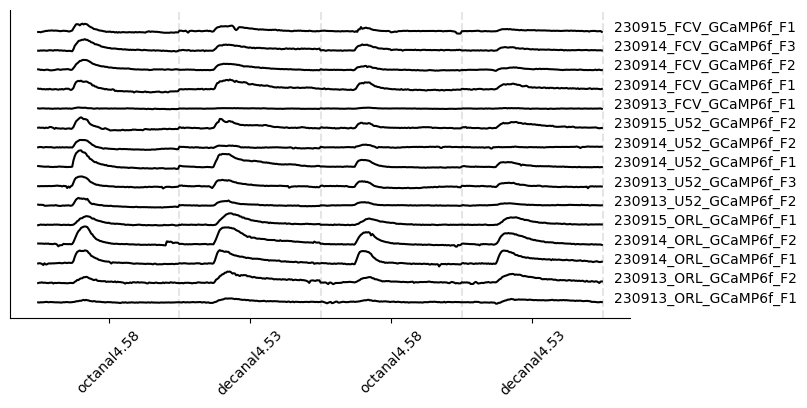

In [68]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

for i,samp in enumerate(mean_activity_within_segment):    
    plt.plot(mean_activity_within_segment[samp] + i*0.02, c='black')  # Offset each trace by i*3
    # print sample name on the right
    plt.text(len(mean_activity_within_segment[samp])*1.02, i*0.02, samp, color='black')

# print the names of the odors on the x-axis
odor_names = []
positions = []
for i,index in enumerate(odor_of_interest_indices):
    odor_names.append(odor_encodings[odor_list[index]])
    positions.append(i*n_frames_to_analyze + n_frames_to_analyze/2)
plt.xticks(positions, odor_names, rotation=45)

# draw vertical lines to separate odors
for i in range(len(odor_of_interest_indices)):
    plt.axvline((i+1)*n_frames_to_analyze, color="black", linestyle="--", alpha=0.1)

plt.yticks([])
# supress grid lines
plt.grid(False)
sns.despine()

## Using the mean activity traces, for each odor, get the maximum intensity during the frames corresponding to that odor.

In [97]:
maxs_by_samp = defaultdict(lambda : defaultdict(list))

for samp in mean_activity_within_segment:
    maxs_per_odor = defaultdict(list)
    # for each odor, extract max value from the corresponding interval
    for i in range(len(odor_of_interest_indices)):
        # get odor name
        odor_of_interest_index = odor_of_interest_indices[i]
        odor = odor_list[odor_of_interest_index]
        odor_name = odor_encodings[odor]

        # since a subset of videos were concatenates, use index i of odor_of_interest_indices to get the corresponding interval
        interval = mean_activity_within_segment[samp][i*n_frames_to_analyze:(i+1)*n_frames_to_analyze]

        maxs_per_odor[odor_name].append(np.max(interval))

    for odor in maxs_per_odor:
        assert len(maxs_per_odor[odor]) <= 2, f" for odor {odor} there were more than 2 trials. This is unexpected."

    maxs_by_samp[samp] = maxs_per_odor  

# tmp = []
# for s in maxs_by_samp:
#     for odor in maxs_by_samp[s]:
#         print(odor)
#         tmp.append(maxs_by_samp[s][odor][1]/maxs_by_samp[s][odor][0]) 
#         # print(int(odor[1])-int(odor[0]))
# sns.histplot(tmp, bins=10)
# print(np.median(tmp))
# sns.despine()

## Convert the data to a DataFrame

In [98]:
df_list = []
for samp in maxs_by_samp:
    df_tmp = pd.DataFrame.from_dict(maxs_by_samp[samp])
    df_tmp['sample'] = samp
    df_tmp['subpop'] = samp.split('_')[1]
    df_tmp['trial'] = df_tmp.index+1
    df_list.append(df_tmp)

df = pd.concat(df_list)
df = df.reset_index(drop=True)
df = pd.melt(df, id_vars=['sample', 'subpop', 'trial'], var_name='odor', value_name='peak_value')

In [99]:
df

,sample,subpop,trial,odor,peak_value
0,230913_ORL_GCaMP6f_F1,ORL,1,octanal4.58,0.002491
1,230913_ORL_GCaMP6f_F1,ORL,2,octanal4.58,0.002574
2,230913_ORL_GCaMP6f_F2,ORL,1,octanal4.58,0.006234
3,230913_ORL_GCaMP6f_F2,ORL,2,octanal4.58,0.006011
4,230914_ORL_GCaMP6f_F1,ORL,1,octanal4.58,0.013534
5,230914_ORL_GCaMP6f_F1,ORL,2,octanal4.58,0.012867
6,230914_ORL_GCaMP6f_F2,ORL,1,octanal4.58,0.018267
7,230914_ORL_GCaMP6f_F2,ORL,2,octanal4.58,0.012412
8,230915_ORL_GCaMP6f_F1,ORL,1,octanal4.58,0.008916
9,230915_ORL_GCaMP6f_F1,ORL,2,octanal4.58,0.006382


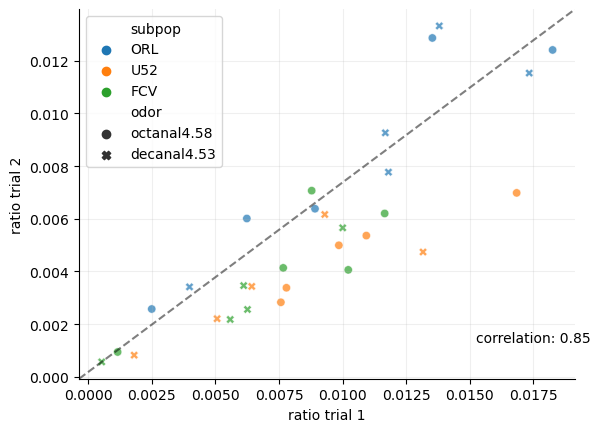

In [79]:
sns.scatterplot(x=list(df[df['trial']==1]['peak_value']),
                y=list(df[df['trial']==2]['peak_value']),
                hue=df[df['trial']==1]['subpop'],
                style=df[df['trial']==1]['odor'],
                alpha=0.7)
plt.xlabel('peak_value trial 1')
plt.ylabel('peak_value trial 2')

# put legend in upper right corner
plt.legend(loc='upper left')
# plot the correlation between the two trials and print this in the upper left corner
corr = np.corrcoef(df[df['trial']==1]['peak_value'], df[df['trial']==2]['peak_value'])[0,1]
plt.text(0.8, 0.1, f"correlation: {corr:.2f}", transform=plt.gca().transAxes)
# add x=y line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, linestyle='--', color='black', alpha=0.5)
# add grid lines 
plt.grid(True, alpha=0.2)
sns.despine()